%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install tqdm
%pip install scikit-learn
%pip install prophet
%pip install plotly
%pip install nbformat

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("ConsumptionDataset.csv")

# Clean column names if needed
df.columns = df.columns.str.strip()

# Parse datetime
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'], infer_datetime_format=True, errors='coerce')

# Create date-based features
df['Date'] = df['Date Time Served'].dt.date
df['Year'] = df['Date Time Served'].dt.year
df['Month'] = df['Date Time Served'].dt.month
df['Weekday'] = df['Date Time Served'].dt.day_name()

# Check missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for negative values
print("\nNegative Values in Key Columns:")
num_cols = ['Opening Balance (ml)', 'Purchase (ml)', 'Consumed (ml)', 'Closing Balance (ml)']
print((df[num_cols] < 0).sum())

# Inventory flow consistency check
df['Expected Closing'] = df['Opening Balance (ml)'] + df['Purchase (ml)'] - df['Consumed (ml)']
df['Discrepancy'] = df['Closing Balance (ml)'] - df['Expected Closing']

# Print a few inconsistent rows (with more than minimal discrepancy)
inconsistencies = df[abs(df['Discrepancy']) > 1e-2]
print("\nSample inconsistent rows (if any):")
print(inconsistencies[['Date Time Served', 'Opening Balance (ml)', 'Purchase (ml)', 'Consumed (ml)', 'Closing Balance (ml)', 'Expected Closing', 'Discrepancy']].head())

# Drop rows with missing datetime and make a safe copy
df_cleaned = df.dropna(subset=['Date Time Served']).copy()

# Summary of cleaning
print("\nCleaning Summary:")
print(f"Original Rows: {len(df)}")
print(f"Rows After Cleaning: {len(df_cleaned)}")
print(f"Dropped Rows: {len(df) - len(df_cleaned)}")

# View structure of cleaned data
print(df_cleaned.info())

# View cleaned dataset
df_cleaned.head()

Missing Values:
Date Time Served        3954
Bar Name                   0
Alcohol Type               0
Brand Name                 0
Opening Balance (ml)       0
Purchase (ml)              0
Consumed (ml)              0
Closing Balance (ml)       0
Date                    3954
Year                    3954
Month                   3954
Weekday                 3954
dtype: int64

Negative Values in Key Columns:
Opening Balance (ml)    0
Purchase (ml)           0
Consumed (ml)           0
Closing Balance (ml)    0
dtype: int64

Sample inconsistent rows (if any):
       Date Time Served  Opening Balance (ml)  Purchase (ml)  Consumed (ml)  \
42  2023-01-03 20:00:00                826.20           0.00         227.73   
58  2023-01-04 10:45:00               2300.00           0.00         349.22   
99  2023-01-06 13:10:00               1427.79           0.00         248.86   
125 2023-01-07 14:01:00               2510.00           0.00         494.68   
143 2023-01-08 14:46:00                126

C:\Users\USER\AppData\Local\Temp\ipykernel_18352\1889034723.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date Time Served'] = pd.to_datetime(df['Date Time Served'], infer_datetime_format=True, errors='coerce')


,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml),Date,Year,Month,Weekday,Expected Closing,Discrepancy
0,2023-01-01 19:35:00,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88,2023-01-01,2023.0,1.0,Sunday,4379.88,0.0
1,2023-01-01 10:07:00,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37,2023-01-01,2023.0,1.0,Sunday,1344.37,0.0
2,2023-01-01 11:26:00,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28,2023-01-01,2023.0,1.0,Sunday,1034.28,0.0
3,2023-01-01 13:53:00,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53,2023-01-01,2023.0,1.0,Sunday,2194.53,0.0
4,2023-01-01 22:28:00,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90,2023-01-01,2023.0,1.0,Sunday,1020.90,0.0


In [2]:
# Aggregate consumption per day per (Bar, Brand)
daily_consumption = df_cleaned.groupby(['Bar Name', 'Brand Name', 'Date'], as_index=False)['Consumed (ml)'].sum()

# Rename for clarity
daily_consumption.rename(columns={'Consumed (ml)': 'Daily Consumption (ml)'}, inplace=True)

# date for time series modeling
daily_consumption.sort_values(by=['Bar Name', 'Brand Name', 'Date'], inplace=True)

# Add time-based features
daily_consumption['Date'] = pd.to_datetime(daily_consumption['Date'])
daily_consumption['Year'] = daily_consumption['Date'].dt.year
daily_consumption['Month'] = daily_consumption['Date'].dt.month
daily_consumption['Weekday'] = daily_consumption['Date'].dt.day_name()
daily_consumption['DayOfWeek'] = daily_consumption['Date'].dt.dayofweek

# Add rolling consumption mean (7-day)
daily_consumption['Rolling_7d'] = (
    daily_consumption.groupby(['Bar Name', 'Brand Name'])['Daily Consumption (ml)']
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

# Preview final aggregated and feature-engineered data
daily_consumption.head()

,Bar Name,Brand Name,Date,Daily Consumption (ml),Year,Month,Weekday,DayOfWeek,Rolling_7d
0,Anderson's Bar,Absolut,2023-01-02,118.62,2023,1,Monday,0,118.620000
1,Anderson's Bar,Absolut,2023-01-05,463.20,2023,1,Thursday,3,290.910000
2,Anderson's Bar,Absolut,2023-01-06,453.02,2023,1,Friday,4,344.946667
3,Anderson's Bar,Absolut,2023-01-08,275.08,2023,1,Sunday,6,327.480000
4,Anderson's Bar,Absolut,2023-01-11,0.00,2023,1,Wednesday,2,261.984000


c:\Users\USER\Desktop\kristalball\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
08:07:14 - cmdstanpy - INFO - Chain [1] start processing
08:07:14 - cmdstanpy - INFO - Chain [1] done processing


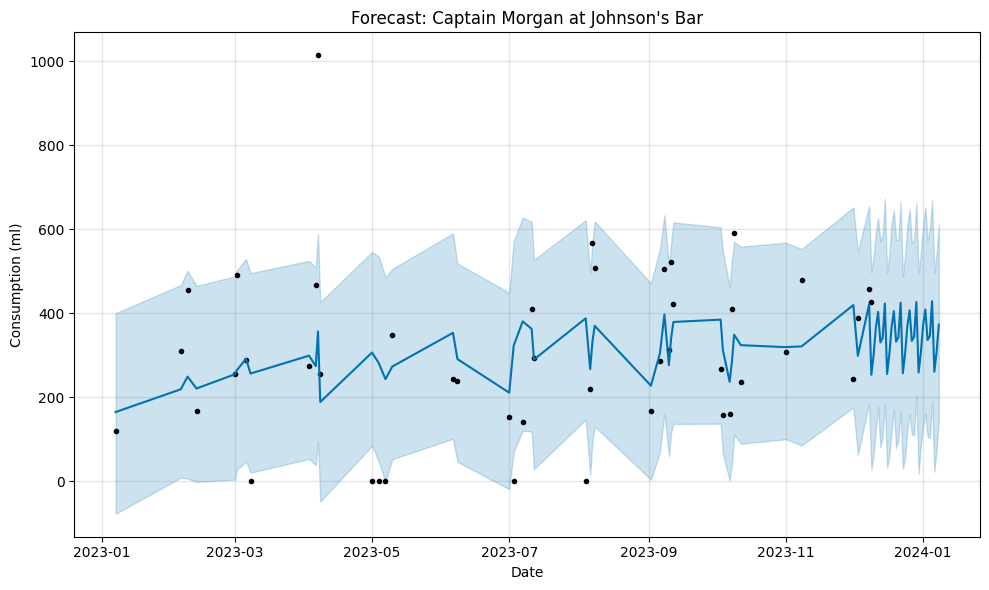

In [3]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Sample pair
bar_sample = "Johnson's Bar"
brand_sample = "Captain Morgan"

# Filter the data
sample_df = daily_consumption[
    (daily_consumption['Bar Name'] == bar_sample) &
    (daily_consumption['Brand Name'] == brand_sample)
].copy()

# Prepare data for Prophet
prophet_df = sample_df[['Date', 'Daily Consumption (ml)']].rename(
    columns={'Date': 'ds', 'Daily Consumption (ml)': 'y'}
)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Initialize and fit the model
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

# Create future dates
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f"Forecast: {brand_sample} at {bar_sample}")
plt.xlabel("Date")
plt.ylabel("Consumption (ml)")
plt.tight_layout()
plt.show()

In [4]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Prepare storage
all_forecasts = []

# Valid pairs with sufficient history
pair_counts = daily_consumption.groupby(['Bar Name', 'Brand Name']).size().reset_index(name='Count')
valid_pairs = pair_counts[pair_counts['Count'] > 20][['Bar Name', 'Brand Name']]

# Forecast for each pair
for index, row in tqdm(valid_pairs.iterrows(), total=valid_pairs.shape[0], desc="Forecasting"):
    bar = row['Bar Name']
    brand = row['Brand Name']
    print(f"Processing: {bar} - {brand}")

    subset = daily_consumption[
        (daily_consumption['Bar Name'] == bar) &
        (daily_consumption['Brand Name'] == brand)
    ].copy()

    prophet_df = subset[['Date', 'Daily Consumption (ml)']].rename(columns={
        'Date': 'ds',
        'Daily Consumption (ml)': 'y'
    })
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_df)

        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)

        future_forecast = forecast.tail(30)
        avg_demand = future_forecast['yhat'].mean()
        high_demand = future_forecast['yhat_upper'].quantile(0.95)

        all_forecasts.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'Forecasted Avg Demand (30d)': round(avg_demand, 2),
            'Forecasted High Demand (95th percentile)': round(high_demand, 2)
        })
    except Exception as e:
        print(f"Error for {bar} - {brand}: {e}")

forecast_results_df = pd.DataFrame(all_forecasts)
forecast_results_df.head()

# Save cleaned data
daily_consumption.to_csv("data.csv", index=False)

Forecasting:   0%|          | 0/83 [00:00<?, ?it/s]08:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing: Anderson's Bar - Absolut


08:07:14 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:   1%|          | 1/83 [00:00<00:24,  3.31it/s]08:07:14 - cmdstanpy - INFO - Chain [1] start processing


Processing: Anderson's Bar - Bacardi


08:07:15 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:   2%|▏         | 2/83 [00:00<00:24,  3.27it/s]08:07:15 - cmdstanpy - INFO - Chain [1] start processing


Processing: Anderson's Bar - Barefoot


08:07:15 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:   4%|▎         | 3/83 [00:00<00:25,  3.12it/s]08:07:15 - cmdstanpy - INFO - Chain [1] start processing
08:07:15 - cmdstanpy - INFO - Chain [1] done processing


Processing: Anderson's Bar - Captain Morgan


Forecasting:   5%|▍         | 4/83 [00:01<00:22,  3.49it/s]08:07:15 - cmdstanpy - INFO - Chain [1] start processing
08:07:15 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:   6%|▌         | 5/83 [00:01<00:17,  4.37it/s]

Processing: Anderson's Bar - Coors
Processing: Anderson's Bar - Grey Goose


08:07:15 - cmdstanpy - INFO - Chain [1] start processing
08:07:16 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:   7%|▋         | 6/83 [00:01<00:16,  4.55it/s]08:07:16 - cmdstanpy - INFO - Chain [1] start processing
08:07:16 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:   8%|▊         | 7/83 [00:01<00:16,  4.75it/s]

Processing: Anderson's Bar - Heineken
Processing: Anderson's Bar - Jack Daniels


08:07:16 - cmdstanpy - INFO - Chain [1] start processing
08:07:16 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  10%|▉         | 8/83 [00:01<00:14,  5.07it/s]08:07:16 - cmdstanpy - INFO - Chain [1] start processing
08:07:16 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  11%|█         | 9/83 [00:02<00:14,  5.25it/s]

Processing: Anderson's Bar - Jameson
Processing: Anderson's Bar - Jim Beam


08:07:16 - cmdstanpy - INFO - Chain [1] start processing
08:07:16 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  12%|█▏        | 10/83 [00:02<00:13,  5.36it/s]08:07:16 - cmdstanpy - INFO - Chain [1] start processing
08:07:16 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  13%|█▎        | 11/83 [00:02<00:12,  5.79it/s]08:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing: Anderson's Bar - Malibu
Processing: Anderson's Bar - Miller


08:07:17 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  14%|█▍        | 12/83 [00:02<00:11,  6.24it/s]08:07:17 - cmdstanpy - INFO - Chain [1] start processing
08:07:17 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  16%|█▌        | 13/83 [00:02<00:11,  6.09it/s]08:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing: Anderson's Bar - Smirnoff
Processing: Anderson's Bar - Sutter Home


08:07:17 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  17%|█▋        | 14/83 [00:02<00:11,  6.18it/s]08:07:17 - cmdstanpy - INFO - Chain [1] start processing
08:07:17 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  18%|█▊        | 15/83 [00:02<00:11,  6.16it/s]

Processing: Anderson's Bar - Yellow Tail
Processing: Brown's Bar - Absolut


08:07:17 - cmdstanpy - INFO - Chain [1] start processing
08:07:17 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  19%|█▉        | 16/83 [00:03<00:10,  6.21it/s]08:07:17 - cmdstanpy - INFO - Chain [1] start processing


Processing: Brown's Bar - Bacardi


08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  20%|██        | 17/83 [00:03<00:13,  5.02it/s]08:07:18 - cmdstanpy - INFO - Chain [1] start processing
08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  22%|██▏       | 18/83 [00:03<00:11,  5.60it/s]08:07:18 - cmdstanpy - INFO - Chain [1] start processing


Processing: Brown's Bar - Barefoot
Processing: Brown's Bar - Captain Morgan


08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  23%|██▎       | 19/83 [00:03<00:10,  5.89it/s]08:07:18 - cmdstanpy - INFO - Chain [1] start processing
08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  24%|██▍       | 20/83 [00:03<00:10,  6.18it/s]

Processing: Brown's Bar - Grey Goose
Processing: Brown's Bar - Jack Daniels


08:07:18 - cmdstanpy - INFO - Chain [1] start processing
08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  25%|██▌       | 21/83 [00:04<00:10,  5.93it/s]08:07:18 - cmdstanpy - INFO - Chain [1] start processing
08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  27%|██▋       | 22/83 [00:04<00:09,  6.40it/s]08:07:18 - cmdstanpy - INFO - Chain [1] start processing


Processing: Brown's Bar - Jameson
Processing: Brown's Bar - Jim Beam


08:07:18 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  28%|██▊       | 23/83 [00:04<00:08,  6.75it/s]08:07:18 - cmdstanpy - INFO - Chain [1] start processing
08:07:19 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  29%|██▉       | 24/83 [00:04<00:08,  6.67it/s]08:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing: Brown's Bar - Malibu
Processing: Brown's Bar - Miller


08:07:19 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  30%|███       | 25/83 [00:04<00:08,  7.00it/s]08:07:19 - cmdstanpy - INFO - Chain [1] start processing
08:07:19 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  31%|███▏      | 26/83 [00:04<00:08,  6.64it/s]

Processing: Brown's Bar - Smirnoff
Processing: Brown's Bar - Sutter Home


08:07:19 - cmdstanpy - INFO - Chain [1] start processing
08:07:19 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  33%|███▎      | 27/83 [00:04<00:08,  6.42it/s]08:07:19 - cmdstanpy - INFO - Chain [1] start processing
08:07:19 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  34%|███▎      | 28/83 [00:05<00:08,  6.48it/s]08:07:19 - cmdstanpy - INFO - Chain [1] start processing


Processing: Brown's Bar - Yellow Tail
Processing: Johnson's Bar - Absolut


08:07:19 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  35%|███▍      | 29/83 [00:05<00:09,  5.42it/s]08:07:19 - cmdstanpy - INFO - Chain [1] start processing
08:07:20 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  36%|███▌      | 30/83 [00:05<00:09,  5.57it/s]

Processing: Johnson's Bar - Barefoot
Processing: Johnson's Bar - Captain Morgan


08:07:20 - cmdstanpy - INFO - Chain [1] start processing
08:07:20 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  37%|███▋      | 31/83 [00:05<00:09,  5.31it/s]08:07:20 - cmdstanpy - INFO - Chain [1] start processing
08:07:20 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  39%|███▊      | 32/83 [00:05<00:09,  5.55it/s]08:07:20 - cmdstanpy - INFO - Chain [1] start processing


Processing: Johnson's Bar - Coors
Processing: Johnson's Bar - Grey Goose


08:07:20 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  40%|███▉      | 33/83 [00:06<00:14,  3.37it/s]08:07:21 - cmdstanpy - INFO - Chain [1] start processing
08:07:21 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  41%|████      | 34/83 [00:06<00:12,  3.89it/s]

Processing: Johnson's Bar - Heineken
Processing: Johnson's Bar - Jameson


08:07:21 - cmdstanpy - INFO - Chain [1] start processing
08:07:21 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  42%|████▏     | 35/83 [00:06<00:11,  4.16it/s]08:07:21 - cmdstanpy - INFO - Chain [1] start processing


Processing: Johnson's Bar - Jim Beam


08:07:21 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  43%|████▎     | 36/83 [00:07<00:12,  3.72it/s]08:07:21 - cmdstanpy - INFO - Chain [1] start processing
08:07:21 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  45%|████▍     | 37/83 [00:07<00:11,  4.16it/s]

Processing: Johnson's Bar - Malibu
Processing: Johnson's Bar - Miller


08:07:21 - cmdstanpy - INFO - Chain [1] start processing
08:07:22 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  46%|████▌     | 38/83 [00:07<00:09,  4.51it/s]08:07:22 - cmdstanpy - INFO - Chain [1] start processing
08:07:22 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  47%|████▋     | 39/83 [00:07<00:08,  5.02it/s]08:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing: Johnson's Bar - Smirnoff
Processing: Johnson's Bar - Sutter Home


08:07:22 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  48%|████▊     | 40/83 [00:07<00:08,  4.88it/s]08:07:22 - cmdstanpy - INFO - Chain [1] start processing
08:07:22 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  49%|████▉     | 41/83 [00:07<00:07,  5.38it/s]08:07:22 - cmdstanpy - INFO - Chain [1] start processing


Processing: Johnson's Bar - Yellow Tail
Processing: Smith's Bar - Absolut


08:07:22 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  51%|█████     | 42/83 [00:08<00:07,  5.33it/s]08:07:22 - cmdstanpy - INFO - Chain [1] start processing
08:07:22 - cmdstanpy - INFO - Chain [1] done processing


Processing: Smith's Bar - Barefoot


Forecasting:  52%|█████▏    | 43/83 [00:08<00:08,  4.99it/s]08:07:23 - cmdstanpy - INFO - Chain [1] start processing
08:07:23 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  53%|█████▎    | 44/83 [00:08<00:07,  5.25it/s]08:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing: Smith's Bar - Captain Morgan
Processing: Smith's Bar - Coors


08:07:23 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  54%|█████▍    | 45/83 [00:08<00:06,  5.49it/s]08:07:23 - cmdstanpy - INFO - Chain [1] start processing
08:07:23 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  55%|█████▌    | 46/83 [00:08<00:06,  6.06it/s]08:07:23 - cmdstanpy - INFO - Chain [1] start processing


Processing: Smith's Bar - Grey Goose
Processing: Smith's Bar - Jack Daniels


08:07:23 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  57%|█████▋    | 47/83 [00:09<00:05,  6.02it/s]08:07:23 - cmdstanpy - INFO - Chain [1] start processing
08:07:23 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  58%|█████▊    | 48/83 [00:09<00:06,  5.82it/s]

Processing: Smith's Bar - Jameson
Processing: Smith's Bar - Jim Beam


08:07:23 - cmdstanpy - INFO - Chain [1] start processing
08:07:23 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  59%|█████▉    | 49/83 [00:09<00:05,  6.16it/s]08:07:24 - cmdstanpy - INFO - Chain [1] start processing
08:07:24 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  60%|██████    | 50/83 [00:09<00:05,  5.87it/s]

Processing: Smith's Bar - Malibu
Processing: Smith's Bar - Miller


08:07:24 - cmdstanpy - INFO - Chain [1] start processing
08:07:24 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  61%|██████▏   | 51/83 [00:09<00:05,  5.59it/s]08:07:24 - cmdstanpy - INFO - Chain [1] start processing
08:07:24 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  63%|██████▎   | 52/83 [00:09<00:05,  5.54it/s]

Processing: Smith's Bar - Smirnoff
Processing: Smith's Bar - Sutter Home


08:07:24 - cmdstanpy - INFO - Chain [1] start processing
08:07:24 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  64%|██████▍   | 53/83 [00:10<00:05,  5.37it/s]08:07:24 - cmdstanpy - INFO - Chain [1] start processing
08:07:24 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  65%|██████▌   | 54/83 [00:10<00:05,  5.34it/s]

Processing: Smith's Bar - Yellow Tail
Processing: Taylor's Bar - Absolut


08:07:25 - cmdstanpy - INFO - Chain [1] start processing
08:07:25 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  66%|██████▋   | 55/83 [00:10<00:05,  5.47it/s]08:07:25 - cmdstanpy - INFO - Chain [1] start processing
08:07:25 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  67%|██████▋   | 56/83 [00:10<00:04,  5.76it/s]

Processing: Taylor's Bar - Bacardi
Processing: Taylor's Bar - Barefoot


08:07:25 - cmdstanpy - INFO - Chain [1] start processing
08:07:25 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  69%|██████▊   | 57/83 [00:10<00:04,  5.22it/s]08:07:25 - cmdstanpy - INFO - Chain [1] start processing
08:07:25 - cmdstanpy - INFO - Chain [1] done processing


Processing: Taylor's Bar - Captain Morgan


Forecasting:  70%|██████▉   | 58/83 [00:11<00:05,  4.98it/s]08:07:25 - cmdstanpy - INFO - Chain [1] start processing
08:07:25 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  71%|███████   | 59/83 [00:11<00:04,  5.03it/s]

Processing: Taylor's Bar - Coors
Processing: Taylor's Bar - Grey Goose


08:07:25 - cmdstanpy - INFO - Chain [1] start processing
08:07:26 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  72%|███████▏  | 60/83 [00:11<00:05,  4.58it/s]08:07:26 - cmdstanpy - INFO - Chain [1] start processing
08:07:26 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  73%|███████▎  | 61/83 [00:11<00:04,  4.71it/s]

Processing: Taylor's Bar - Heineken
Processing: Taylor's Bar - Jack Daniels


08:07:26 - cmdstanpy - INFO - Chain [1] start processing
08:07:26 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  75%|███████▍  | 62/83 [00:11<00:04,  4.64it/s]08:07:26 - cmdstanpy - INFO - Chain [1] start processing
08:07:26 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  76%|███████▌  | 63/83 [00:12<00:04,  4.79it/s]

Processing: Taylor's Bar - Jameson
Processing: Taylor's Bar - Jim Beam


08:07:26 - cmdstanpy - INFO - Chain [1] start processing
08:07:26 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  77%|███████▋  | 64/83 [00:12<00:04,  4.57it/s]08:07:27 - cmdstanpy - INFO - Chain [1] start processing


Processing: Taylor's Bar - Malibu


08:07:27 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  78%|███████▊  | 65/83 [00:12<00:04,  3.88it/s]08:07:27 - cmdstanpy - INFO - Chain [1] start processing
08:07:27 - cmdstanpy - INFO - Chain [1] done processing


Processing: Taylor's Bar - Miller


Forecasting:  80%|███████▉  | 66/83 [00:12<00:04,  4.05it/s]08:07:27 - cmdstanpy - INFO - Chain [1] start processing
08:07:27 - cmdstanpy - INFO - Chain [1] done processing


Processing: Taylor's Bar - Smirnoff


Forecasting:  81%|████████  | 67/83 [00:13<00:04,  4.00it/s]08:07:27 - cmdstanpy - INFO - Chain [1] start processing
08:07:28 - cmdstanpy - INFO - Chain [1] done processing


Processing: Taylor's Bar - Sutter Home


Forecasting:  82%|████████▏ | 68/83 [00:13<00:03,  4.10it/s]08:07:28 - cmdstanpy - INFO - Chain [1] start processing
08:07:28 - cmdstanpy - INFO - Chain [1] done processing


Processing: Taylor's Bar - Yellow Tail


Forecasting:  83%|████████▎ | 69/83 [00:13<00:03,  4.21it/s]08:07:28 - cmdstanpy - INFO - Chain [1] start processing
08:07:28 - cmdstanpy - INFO - Chain [1] done processing


Processing: Thomas's Bar - Absolut


Forecasting:  84%|████████▍ | 70/83 [00:13<00:03,  4.28it/s]08:07:28 - cmdstanpy - INFO - Chain [1] start processing


Processing: Thomas's Bar - Bacardi


08:07:28 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  86%|████████▌ | 71/83 [00:14<00:02,  4.19it/s]08:07:28 - cmdstanpy - INFO - Chain [1] start processing
08:07:28 - cmdstanpy - INFO - Chain [1] done processing


Processing: Thomas's Bar - Barefoot


Forecasting:  87%|████████▋ | 72/83 [00:14<00:02,  4.26it/s]08:07:29 - cmdstanpy - INFO - Chain [1] start processing
08:07:29 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  88%|████████▊ | 73/83 [00:14<00:02,  4.53it/s]

Processing: Thomas's Bar - Budweiser
Processing: Thomas's Bar - Captain Morgan


08:07:29 - cmdstanpy - INFO - Chain [1] start processing
08:07:29 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  89%|████████▉ | 74/83 [00:14<00:02,  4.23it/s]08:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing: Thomas's Bar - Grey Goose


08:07:29 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  90%|█████████ | 75/83 [00:15<00:02,  3.89it/s]08:07:29 - cmdstanpy - INFO - Chain [1] start processing


Processing: Thomas's Bar - Jack Daniels


08:07:30 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  92%|█████████▏| 76/83 [00:15<00:01,  3.64it/s]08:07:30 - cmdstanpy - INFO - Chain [1] start processing
08:07:30 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  93%|█████████▎| 77/83 [00:15<00:01,  3.97it/s]

Processing: Thomas's Bar - Jameson
Processing: Thomas's Bar - Jim Beam


08:07:30 - cmdstanpy - INFO - Chain [1] start processing
08:07:30 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  94%|█████████▍| 78/83 [00:15<00:01,  4.24it/s]08:07:30 - cmdstanpy - INFO - Chain [1] start processing
08:07:30 - cmdstanpy - INFO - Chain [1] done processing


Processing: Thomas's Bar - Malibu


Forecasting:  95%|█████████▌| 79/83 [00:16<00:00,  4.42it/s]08:07:30 - cmdstanpy - INFO - Chain [1] start processing
08:07:30 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  96%|█████████▋| 80/83 [00:16<00:00,  4.73it/s]

Processing: Thomas's Bar - Miller
Processing: Thomas's Bar - Smirnoff


08:07:30 - cmdstanpy - INFO - Chain [1] start processing
08:07:31 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  98%|█████████▊| 81/83 [00:16<00:00,  4.60it/s]08:07:31 - cmdstanpy - INFO - Chain [1] start processing
08:07:31 - cmdstanpy - INFO - Chain [1] done processing
Forecasting:  99%|█████████▉| 82/83 [00:16<00:00,  4.80it/s]

Processing: Thomas's Bar - Sutter Home
Processing: Thomas's Bar - Yellow Tail


08:07:31 - cmdstanpy - INFO - Chain [1] start processing
08:07:31 - cmdstanpy - INFO - Chain [1] done processing
Forecasting: 100%|██████████| 83/83 [00:16<00:00,  4.92it/s]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Count unique days per (Bar, Brand) pair using the correct dataframe name and columns
# Use 'daily_consumption' dataframe as it already has daily aggregated data and correct column names
pair_counts = daily_consumption.groupby(['Bar Name', 'Brand Name'])['Date'].nunique().reset_index()
pair_counts.columns = ['Bar Name', 'Brand Name', 'Unique Days']

# Keep only pairs with at least 20 unique days
eval_pairs = pair_counts[pair_counts['Unique Days'] >= 20]

# Use all valid pairs (no sampling)
sampled_pairs = eval_pairs.copy()

evaluation_results = []

for _, row in sampled_pairs.iterrows():
    bar = row['Bar Name']
    brand = row['Brand Name']

    # Filter the daily_consumption dataframe for the current pair
    pair_data = daily_consumption[(daily_consumption['Bar Name'] == bar) & (daily_consumption['Brand Name'] == brand)].copy()

    # Rename columns for Prophet
    prophet_data = pair_data[['Date', 'Daily Consumption (ml)']].rename(columns={'Date': 'ds', 'Daily Consumption (ml)': 'y'})

    # Ensure 'ds' is datetime type
    prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

    # Train-test split: last 7 days as test
    # Ensure there are enough rows before splitting
    if len(prophet_data) < 14 + 7: # Need at least 14 for training + 7 for test
         print(f"Skipping {bar} - {brand}: Not enough data ({len(prophet_data)} days) for training and testing.")
         continue

    train = prophet_data.iloc[:-7]
    test = prophet_data.iloc[-7:]

    # Skip if not enough training data for Prophet
    if len(train) < 2: # Prophet needs at least 2 data points
         print(f"Skipping {bar} - {brand}: Not enough training data ({len(train)} days) for Prophet.")
         continue

    try:
        # Fit Prophet
        model = Prophet()
        model.fit(train)

        # Forecast 7 days ahead
        future = model.make_future_dataframe(periods=len(test), freq='D') # Make future dataframe length of test set
        forecast = model.predict(future)

        # Merge forecast with test set based on the date ('ds' in forecast, 'ds' in test)
        merged = test.merge(forecast[['ds', 'yhat']], on='ds', how='inner')

        # Skip if not enough matching test data
        if len(merged) < 3: # Need at least 3 overlapping points for meaningful metrics
             print(f"Skipping {bar} - {brand}: Only {len(merged)} overlapping test points.")
             continue

        # Metrics
        actual = merged['y']
        predicted = merged['yhat']

        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        # Avoid divide-by-zero in MAPE
        mape = np.nan # Initialize mape as NaN
        if (actual != 0).any(): # Only calculate MAPE if there is at least one non-zero actual value
             # Replace 0s in actual with NaN for the division, then take mean, and handle NaN if all actuals were 0
             mape = (abs((actual - predicted) / actual.replace(0, np.nan))).mean() * 100

        evaluation_results.append({
            'Bar Name': bar,
            'Brand Name': brand,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2) if not np.isnan(mape) else np.nan, # Handle NaN if MAPE couldn't be calculated
            'Test Samples': len(actual) # Number of actual test samples used for metrics
        })

    except Exception as e:
        print(f"Error for {bar} - {brand}: {e}")

# Convert to DataFrame
eval_df = pd.DataFrame(evaluation_results)

# Display
print("\nEvaluation Results:")
display(eval_df.head(10))

eval_df.to_csv("forecast_evaluation_metrics.csv", index=False)

08:07:32 - cmdstanpy - INFO - Chain [1] start processing
08:07:32 - cmdstanpy - INFO - Chain [1] done processing
08:07:32 - cmdstanpy - INFO - Chain [1] start processing
08:07:32 - cmdstanpy - INFO - Chain [1] done processing
08:07:32 - cmdstanpy - INFO - Chain [1] start processing


Skipping Anderson's Bar - Absolut: Only 0 overlapping test points.
Skipping Anderson's Bar - Bacardi: Only 1 overlapping test points.


08:07:32 - cmdstanpy - INFO - Chain [1] done processing
08:07:32 - cmdstanpy - INFO - Chain [1] start processing
08:07:32 - cmdstanpy - INFO - Chain [1] done processing


Skipping Anderson's Bar - Barefoot: Only 1 overlapping test points.
Skipping Anderson's Bar - Captain Morgan: Only 0 overlapping test points.


08:07:32 - cmdstanpy - INFO - Chain [1] start processing
08:07:33 - cmdstanpy - INFO - Chain [1] done processing
08:07:33 - cmdstanpy - INFO - Chain [1] start processing
08:07:33 - cmdstanpy - INFO - Chain [1] done processing


Skipping Anderson's Bar - Coors: Only 0 overlapping test points.
Skipping Anderson's Bar - Grey Goose: Only 1 overlapping test points.


08:07:33 - cmdstanpy - INFO - Chain [1] start processing
08:07:33 - cmdstanpy - INFO - Chain [1] done processing
08:07:33 - cmdstanpy - INFO - Chain [1] start processing
08:07:33 - cmdstanpy - INFO - Chain [1] done processing
08:07:33 - cmdstanpy - INFO - Chain [1] start processing


Skipping Anderson's Bar - Heineken: Only 1 overlapping test points.
Skipping Anderson's Bar - Jack Daniels: Only 1 overlapping test points.


08:07:33 - cmdstanpy - INFO - Chain [1] done processing
08:07:33 - cmdstanpy - INFO - Chain [1] start processing


Skipping Anderson's Bar - Jameson: Only 1 overlapping test points.


08:07:33 - cmdstanpy - INFO - Chain [1] done processing
08:07:33 - cmdstanpy - INFO - Chain [1] start processing
08:07:33 - cmdstanpy - INFO - Chain [1] done processing
08:07:34 - cmdstanpy - INFO - Chain [1] start processing


Skipping Anderson's Bar - Jim Beam: Only 0 overlapping test points.
Skipping Anderson's Bar - Malibu: Only 2 overlapping test points.


08:07:34 - cmdstanpy - INFO - Chain [1] done processing
08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing


Skipping Anderson's Bar - Miller: Only 0 overlapping test points.
Skipping Anderson's Bar - Smirnoff: Only 0 overlapping test points.


08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing
08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing
08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing


Skipping Anderson's Bar - Sutter Home: Only 2 overlapping test points.
Skipping Anderson's Bar - Yellow Tail: Only 1 overlapping test points.


08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing
08:07:34 - cmdstanpy - INFO - Chain [1] start processing


Skipping Brown's Bar - Absolut: Only 0 overlapping test points.
Skipping Brown's Bar - Bacardi: Only 1 overlapping test points.


08:07:34 - cmdstanpy - INFO - Chain [1] done processing
08:07:34 - cmdstanpy - INFO - Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing
08:07:35 - cmdstanpy - INFO - Chain [1] start processing
08:07:35 - cmdstanpy - INFO - Chain [1] done processing


Skipping Brown's Bar - Barefoot: Only 0 overlapping test points.
Skipping Brown's Bar - Captain Morgan: Only 1 overlapping test points.


08:07:35 - cmdstanpy - INFO - Chain [1] start processing
08:07:35 - cmdstanpy - INFO - Chain [1] done processing
08:07:35 - cmdstanpy - INFO - Chain [1] start processing
08:07:35 - cmdstanpy - INFO - Chain [1] done processing


Skipping Brown's Bar - Grey Goose: Only 1 overlapping test points.
Skipping Brown's Bar - Heineken: Not enough data (20 days) for training and testing.
Skipping Brown's Bar - Jack Daniels: Only 1 overlapping test points.


08:07:35 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
from prophet.plot import plot_plotly

# Visualize forecast for a specific pair
def plot_forecast(forecast_data, model_obj, title):
    # Use the provided forecast_data and model_obj
    fig = plot_plotly(model_obj, forecast_data)
    fig.update_layout(title=title, xaxis_title="Date", yaxis_title="Predicted Sales")
    fig.show()

# Assuming the 'model' and 'forecast' from the "Johnson's Bar" - "Captain Morgan" example are still in scope.
plot_forecast(forecast, model, "Forecast: Johnson's Bar - Captain Morgan")

In [ ]:
def recommend_inventory(forecast_df, bar_name, brand_name, days=14, buffer_percent=0.10):
    """
    Estimate inventory needed for the next `days` using Prophet forecast
    Adds a buffer (default 10%) for safety stock
    """
    # Get min date from forecast as the start of prediction
    last_date = forecast_df['ds'].min()
    future = forecast_df[forecast_df['ds'] >= last_date].head(days)

    if future.empty or len(future) < days:
        print(f" Not enough future data for {bar_name} - {brand_name}")
        return None

    # Total demand + buffer
    total_demand = future['yhat'].sum()
    buffer = total_demand * buffer_percent
    recommended_stock = round(total_demand + buffer, 2)

    print(f" {bar_name} - {brand_name}: Recommend {recommended_stock} units for next {days} days.")
    return recommended_stock

In [ ]:
for index, row in valid_pairs.iterrows():
    bar_name = row['Bar Name']
    brand_name = row['Brand Name']

    # Filter the data for the current pair
    history_df = daily_consumption[
        (daily_consumption['Bar Name'] == bar_name) &
        (daily_consumption['Brand Name'] == brand_name)
    ].copy().sort_values('Date')

    # Prepare data for Prophet (rename columns and convert date)
    prophet_df = history_df[['Date', 'Daily Consumption (ml)']].rename(columns={
        'Date': 'ds',
        'Daily Consumption (ml)': 'y'
    })
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_df)

        # Forecast next 30 days
        future_df = model.make_future_dataframe(periods=30)
        forecast = model.predict(future_df)

        # Visualize
        plot_forecast(forecast, model, f"Forecast: {bar_name} - {brand_name}")

        # Inventory recommendation for next 14 days
        recommend_inventory(forecast, bar_name, brand_name, days=14, buffer_percent=0.10)

    except Exception as e:
        print(f" Error forecasting or recommending for {bar_name} - {brand_name}: {e}")

07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] done processing


07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Absolut: Recommend 2594.33 units for next 14 days.


 Anderson's Bar - Bacardi: Recommend 4964.97 units for next 14 days.


07:55:19 - cmdstanpy - INFO - Chain [1] start processing
07:55:19 - cmdstanpy - INFO - Chain [1] done processing


07:55:19 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Barefoot: Recommend 4675.93 units for next 14 days.


07:55:20 - cmdstanpy - INFO - Chain [1] done processing


07:55:20 - cmdstanpy - INFO - Chain [1] start processing
07:55:20 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Captain Morgan: Recommend 5207.58 units for next 14 days.


07:55:20 - cmdstanpy - INFO - Chain [1] start processing
07:55:20 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Coors: Recommend 5445.37 units for next 14 days.


07:55:20 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Grey Goose: Recommend 5673.15 units for next 14 days.


07:55:20 - cmdstanpy - INFO - Chain [1] done processing


07:55:21 - cmdstanpy - INFO - Chain [1] start processing
07:55:21 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Heineken: Recommend 6348.68 units for next 14 days.


07:55:21 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Jack Daniels: Recommend 4296.74 units for next 14 days.


07:55:21 - cmdstanpy - INFO - Chain [1] done processing


07:55:21 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Jameson: Recommend 4772.24 units for next 14 days.


07:55:21 - cmdstanpy - INFO - Chain [1] done processing


07:55:22 - cmdstanpy - INFO - Chain [1] start processing
07:55:22 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Jim Beam: Recommend 4984.82 units for next 14 days.


07:55:22 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Malibu: Recommend 3665.19 units for next 14 days.


07:55:22 - cmdstanpy - INFO - Chain [1] done processing


07:55:22 - cmdstanpy - INFO - Chain [1] start processing
07:55:22 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Miller: Recommend 5592.6 units for next 14 days.


07:55:23 - cmdstanpy - INFO - Chain [1] start processing
07:55:23 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Smirnoff: Recommend 5514.1 units for next 14 days.


07:55:23 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Sutter Home: Recommend 3801.11 units for next 14 days.


07:55:23 - cmdstanpy - INFO - Chain [1] done processing


07:55:23 - cmdstanpy - INFO - Chain [1] start processing
07:55:23 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Yellow Tail: Recommend 5651.72 units for next 14 days.


07:55:24 - cmdstanpy - INFO - Chain [1] start processing
07:55:24 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Absolut: Recommend 4865.33 units for next 14 days.


07:55:24 - cmdstanpy - INFO - Chain [1] start processing


 Brown's Bar - Bacardi: Recommend 3919.23 units for next 14 days.


07:55:24 - cmdstanpy - INFO - Chain [1] done processing


07:55:24 - cmdstanpy - INFO - Chain [1] start processing
07:55:24 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Barefoot: Recommend 5449.05 units for next 14 days.


07:55:24 - cmdstanpy - INFO - Chain [1] start processing
07:55:25 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Captain Morgan: Recommend 3724.89 units for next 14 days.


07:55:25 - cmdstanpy - INFO - Chain [1] start processing
07:55:25 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Grey Goose: Recommend 5688.77 units for next 14 days.


07:55:25 - cmdstanpy - INFO - Chain [1] start processing
07:55:25 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Jack Daniels: Recommend 6076.26 units for next 14 days.


07:55:25 - cmdstanpy - INFO - Chain [1] start processing


 Brown's Bar - Jameson: Recommend 5239.58 units for next 14 days.


07:55:26 - cmdstanpy - INFO - Chain [1] done processing


07:55:26 - cmdstanpy - INFO - Chain [1] start processing
07:55:26 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Jim Beam: Recommend 4645.32 units for next 14 days.


07:55:26 - cmdstanpy - INFO - Chain [1] start processing


 Brown's Bar - Malibu: Recommend 3622.14 units for next 14 days.


07:55:26 - cmdstanpy - INFO - Chain [1] done processing


07:55:26 - cmdstanpy - INFO - Chain [1] start processing
07:55:26 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Miller: Recommend 4328.62 units for next 14 days.


07:55:27 - cmdstanpy - INFO - Chain [1] start processing
07:55:27 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Smirnoff: Recommend 2483.82 units for next 14 days.


07:55:27 - cmdstanpy - INFO - Chain [1] start processing


 Brown's Bar - Sutter Home: Recommend 3529.43 units for next 14 days.


07:55:27 - cmdstanpy - INFO - Chain [1] done processing


07:55:27 - cmdstanpy - INFO - Chain [1] start processing


 Brown's Bar - Yellow Tail: Recommend 5338.41 units for next 14 days.


07:55:28 - cmdstanpy - INFO - Chain [1] done processing


07:55:28 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Absolut: Recommend 4769.45 units for next 14 days.


07:55:28 - cmdstanpy - INFO - Chain [1] done processing


07:55:28 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Barefoot: Recommend 4611.76 units for next 14 days.


07:55:28 - cmdstanpy - INFO - Chain [1] done processing


07:55:29 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Captain Morgan: Recommend 3991.82 units for next 14 days.


07:55:29 - cmdstanpy - INFO - Chain [1] done processing


07:55:29 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Coors: Recommend 5633.51 units for next 14 days.


07:55:29 - cmdstanpy - INFO - Chain [1] done processing


07:55:30 - cmdstanpy - INFO - Chain [1] start processing
07:55:30 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Grey Goose: Recommend 5356.26 units for next 14 days.


07:55:30 - cmdstanpy - INFO - Chain [1] start processing
07:55:30 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Heineken: Recommend 5020.24 units for next 14 days.


07:55:30 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Jameson: Recommend 3682.76 units for next 14 days.


07:55:30 - cmdstanpy - INFO - Chain [1] done processing


07:55:31 - cmdstanpy - INFO - Chain [1] start processing
07:55:31 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Jim Beam: Recommend 2741.15 units for next 14 days.


07:55:31 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Malibu: Recommend 6611.76 units for next 14 days.


07:55:31 - cmdstanpy - INFO - Chain [1] done processing


07:55:31 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Miller: Recommend 3659.35 units for next 14 days.


07:55:31 - cmdstanpy - INFO - Chain [1] done processing


07:55:32 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Smirnoff: Recommend 4693.67 units for next 14 days.


07:55:32 - cmdstanpy - INFO - Chain [1] done processing


07:55:32 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Sutter Home: Recommend 5429.38 units for next 14 days.


07:55:32 - cmdstanpy - INFO - Chain [1] done processing


07:55:32 - cmdstanpy - INFO - Chain [1] start processing
07:55:33 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Yellow Tail: Recommend 4307.36 units for next 14 days.


07:55:33 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Absolut: Recommend 5890.64 units for next 14 days.


07:55:33 - cmdstanpy - INFO - Chain [1] done processing


07:55:33 - cmdstanpy - INFO - Chain [1] start processing
07:55:33 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Barefoot: Recommend 4981.55 units for next 14 days.


07:55:33 - cmdstanpy - INFO - Chain [1] start processing
07:55:34 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Captain Morgan: Recommend 4974.84 units for next 14 days.


07:55:34 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Coors: Recommend 4746.81 units for next 14 days.


07:55:34 - cmdstanpy - INFO - Chain [1] done processing


07:55:34 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Grey Goose: Recommend 5030.71 units for next 14 days.


07:55:34 - cmdstanpy - INFO - Chain [1] done processing


07:55:34 - cmdstanpy - INFO - Chain [1] start processing
07:55:35 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Jack Daniels: Recommend 4356.7 units for next 14 days.


07:55:35 - cmdstanpy - INFO - Chain [1] start processing
07:55:35 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Jameson: Recommend 2738.92 units for next 14 days.


07:55:35 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Jim Beam: Recommend 4877.96 units for next 14 days.


07:55:35 - cmdstanpy - INFO - Chain [1] done processing


07:55:36 - cmdstanpy - INFO - Chain [1] start processing
07:55:36 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Malibu: Recommend 4859.91 units for next 14 days.


07:55:36 - cmdstanpy - INFO - Chain [1] start processing
07:55:36 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Miller: Recommend 5292.33 units for next 14 days.


07:55:36 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Smirnoff: Recommend 2886.79 units for next 14 days.


07:55:36 - cmdstanpy - INFO - Chain [1] done processing


07:55:37 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Sutter Home: Recommend 4065.54 units for next 14 days.


07:55:37 - cmdstanpy - INFO - Chain [1] done processing


07:55:37 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Yellow Tail: Recommend 5133.99 units for next 14 days.


07:55:37 - cmdstanpy - INFO - Chain [1] done processing


07:55:37 - cmdstanpy - INFO - Chain [1] start processing
07:55:38 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Absolut: Recommend 4843.67 units for next 14 days.


07:55:38 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Bacardi: Recommend 4572.04 units for next 14 days.


07:55:38 - cmdstanpy - INFO - Chain [1] done processing


07:55:38 - cmdstanpy - INFO - Chain [1] start processing
07:55:38 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Barefoot: Recommend 4745.21 units for next 14 days.


07:55:38 - cmdstanpy - INFO - Chain [1] start processing
07:55:39 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Captain Morgan: Recommend 6024.19 units for next 14 days.


07:55:39 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Coors: Recommend 4643.64 units for next 14 days.


07:55:39 - cmdstanpy - INFO - Chain [1] done processing


07:55:39 - cmdstanpy - INFO - Chain [1] start processing
07:55:39 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Grey Goose: Recommend 5051.65 units for next 14 days.


07:55:39 - cmdstanpy - INFO - Chain [1] start processing
07:55:40 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Heineken: Recommend 3269.48 units for next 14 days.


 Taylor's Bar - Jack Daniels: Recommend 3705.32 units for next 14 days.


07:55:40 - cmdstanpy - INFO - Chain [1] start processing
07:55:40 - cmdstanpy - INFO - Chain [1] done processing


07:55:40 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Jameson: Recommend 4567.94 units for next 14 days.


07:55:40 - cmdstanpy - INFO - Chain [1] done processing


07:55:41 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Jim Beam: Recommend 4809.96 units for next 14 days.


07:55:41 - cmdstanpy - INFO - Chain [1] done processing


07:55:41 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Malibu: Recommend 4019.18 units for next 14 days.


07:55:41 - cmdstanpy - INFO - Chain [1] done processing


07:55:42 - cmdstanpy - INFO - Chain [1] start processing
07:55:42 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Miller: Recommend 3722.96 units for next 14 days.


07:55:42 - cmdstanpy - INFO - Chain [1] start processing
07:55:42 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Smirnoff: Recommend 4984.97 units for next 14 days.


07:55:43 - cmdstanpy - INFO - Chain [1] start processing
07:55:43 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Sutter Home: Recommend 3413.39 units for next 14 days.


07:55:43 - cmdstanpy - INFO - Chain [1] start processing
07:55:43 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Yellow Tail: Recommend 3900.3 units for next 14 days.


07:55:43 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Absolut: Recommend 5011.52 units for next 14 days.


07:55:43 - cmdstanpy - INFO - Chain [1] done processing


07:55:44 - cmdstanpy - INFO - Chain [1] start processing
07:55:44 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Bacardi: Recommend 5969.85 units for next 14 days.


07:55:44 - cmdstanpy - INFO - Chain [1] start processing
07:55:44 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Barefoot: Recommend 4737.98 units for next 14 days.


07:55:44 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Budweiser: Recommend 4257.38 units for next 14 days.


07:55:44 - cmdstanpy - INFO - Chain [1] done processing


07:55:45 - cmdstanpy - INFO - Chain [1] start processing
07:55:45 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Captain Morgan: Recommend 4448.59 units for next 14 days.


07:55:45 - cmdstanpy - INFO - Chain [1] start processing
07:55:45 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Grey Goose: Recommend 5297.88 units for next 14 days.


 Thomas's Bar - Jack Daniels: Recommend 4956.06 units for next 14 days.


07:55:46 - cmdstanpy - INFO - Chain [1] start processing
07:55:46 - cmdstanpy - INFO - Chain [1] done processing


07:55:46 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Jameson: Recommend 3812.49 units for next 14 days.


07:55:46 - cmdstanpy - INFO - Chain [1] done processing


07:55:47 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Jim Beam: Recommend 4768.76 units for next 14 days.


07:55:47 - cmdstanpy - INFO - Chain [1] done processing


07:55:48 - cmdstanpy - INFO - Chain [1] start processing
07:55:48 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Malibu: Recommend 4054.43 units for next 14 days.


07:55:48 - cmdstanpy - INFO - Chain [1] start processing
07:55:48 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Miller: Recommend 4827.53 units for next 14 days.


 Thomas's Bar - Smirnoff: Recommend 4480.64 units for next 14 days.


07:55:49 - cmdstanpy - INFO - Chain [1] start processing
07:55:49 - cmdstanpy - INFO - Chain [1] done processing


07:55:50 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Sutter Home: Recommend 3514.97 units for next 14 days.


07:55:50 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Yellow Tail: Recommend 3219.25 units for next 14 days.


In [ ]:
# Initialize a list to store recommendations
recommendations = []

# Changed 'successful_pairs' to 'valid_pairs'
for index, row in valid_pairs.iterrows():
    bar_name = row['Bar Name']
    brand_name = row['Brand Name']

    # Filter the data for the current pair
    history_df = daily_consumption[
        (daily_consumption['Bar Name'] == bar_name) &
        (daily_consumption['Brand Name'] == brand_name)
    ].copy().sort_values('Date')

    # Prepare data for Prophet (rename columns and convert date)
    prophet_df = history_df[['Date', 'Daily Consumption (ml)']].rename(columns={
        'Date': 'ds',
        'Daily Consumption (ml)': 'y'
    })
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True)
        model.fit(prophet_df)

        # Create future dataframe for forecasting (e.g., next 30 days)
        future_df = model.make_future_dataframe(periods=30)
        forecast = model.predict(future_df)

        # Recommend inventory and collect the result
        recommended_stock = recommend_inventory(forecast, bar_name, brand_name, days=14, buffer_percent=0.10)

        # Only append if a recommendation was successfully generated
        if recommended_stock is not None:
             recommendations.append({
                 'Bar Name': bar_name,
                 'Brand Name': brand_name,
                 'Recommended Stock': recommended_stock
             })

    except Exception as e:
        print(f" Error forecasting or recommending for {bar_name} - {brand_name}: {e}")

# Create the recommendations DataFrame after the loop
recommendations_df = pd.DataFrame(recommendations)

# Now proceed with ranking using the correct column name 'Bar Name'
if not recommendations_df.empty:
    ranking = recommendations_df.groupby('Bar Name')['Recommended Stock'].sum().reset_index()
    ranking = ranking.sort_values(by='Recommended Stock', ascending=False)

    print(" Top Bars by Demand Forecast:")
    display(ranking.head(5))

    print(" Lowest Demand Bars:")
    display(ranking.tail(5))

    display(recommendations_df.head()) # Display the full recommendations df head as in the original code

else:
    print("No recommendations were generated.")

07:55:51 - cmdstanpy - INFO - Chain [1] start processing
07:55:51 - cmdstanpy - INFO - Chain [1] done processing
07:55:51 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Absolut: Recommend 2594.33 units for next 14 days.


07:55:51 - cmdstanpy - INFO - Chain [1] done processing
07:55:51 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Bacardi: Recommend 4964.97 units for next 14 days.


07:55:51 - cmdstanpy - INFO - Chain [1] done processing
07:55:52 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Barefoot: Recommend 4675.93 units for next 14 days.


07:55:52 - cmdstanpy - INFO - Chain [1] done processing
07:55:52 - cmdstanpy - INFO - Chain [1] start processing
07:55:52 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Captain Morgan: Recommend 5207.58 units for next 14 days.


07:55:52 - cmdstanpy - INFO - Chain [1] start processing
07:55:52 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Coors: Recommend 5445.37 units for next 14 days.


07:55:52 - cmdstanpy - INFO - Chain [1] start processing
07:55:53 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Grey Goose: Recommend 5673.15 units for next 14 days.


07:55:53 - cmdstanpy - INFO - Chain [1] start processing
07:55:53 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Heineken: Recommend 6348.68 units for next 14 days.


07:55:53 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Jack Daniels: Recommend 4296.74 units for next 14 days.


07:55:53 - cmdstanpy - INFO - Chain [1] done processing
07:55:53 - cmdstanpy - INFO - Chain [1] start processing


 Anderson's Bar - Jameson: Recommend 4772.24 units for next 14 days.


07:55:53 - cmdstanpy - INFO - Chain [1] done processing
07:55:54 - cmdstanpy - INFO - Chain [1] start processing
07:55:54 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Jim Beam: Recommend 4984.82 units for next 14 days.
 Anderson's Bar - Malibu: Recommend 3665.19 units for next 14 days.


07:55:54 - cmdstanpy - INFO - Chain [1] start processing
07:55:54 - cmdstanpy - INFO - Chain [1] done processing
07:55:54 - cmdstanpy - INFO - Chain [1] start processing
07:55:54 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Miller: Recommend 5592.6 units for next 14 days.


07:55:54 - cmdstanpy - INFO - Chain [1] start processing
07:55:54 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Smirnoff: Recommend 5514.1 units for next 14 days.


07:55:55 - cmdstanpy - INFO - Chain [1] start processing
07:55:55 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Sutter Home: Recommend 3801.11 units for next 14 days.


07:55:55 - cmdstanpy - INFO - Chain [1] start processing
07:55:55 - cmdstanpy - INFO - Chain [1] done processing


 Anderson's Bar - Yellow Tail: Recommend 5651.72 units for next 14 days.


07:55:55 - cmdstanpy - INFO - Chain [1] start processing
07:55:55 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Absolut: Recommend 4865.33 units for next 14 days.


07:55:55 - cmdstanpy - INFO - Chain [1] start processing
07:55:55 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Bacardi: Recommend 3919.23 units for next 14 days.


07:55:56 - cmdstanpy - INFO - Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Barefoot: Recommend 5449.05 units for next 14 days.


07:55:56 - cmdstanpy - INFO - Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Captain Morgan: Recommend 3724.89 units for next 14 days.


07:55:56 - cmdstanpy - INFO - Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Grey Goose: Recommend 5688.77 units for next 14 days.


07:55:56 - cmdstanpy - INFO - Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Jack Daniels: Recommend 6076.26 units for next 14 days.


07:55:57 - cmdstanpy - INFO - Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Jameson: Recommend 5239.58 units for next 14 days.


07:55:57 - cmdstanpy - INFO - Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Jim Beam: Recommend 4645.32 units for next 14 days.
 Brown's Bar - Malibu: Recommend 3622.14 units for next 14 days.


07:55:57 - cmdstanpy - INFO - Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing
07:55:57 - cmdstanpy - INFO - Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Miller: Recommend 4328.62 units for next 14 days.


07:55:58 - cmdstanpy - INFO - Chain [1] start processing
07:55:58 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Smirnoff: Recommend 2483.82 units for next 14 days.


07:55:58 - cmdstanpy - INFO - Chain [1] start processing
07:55:58 - cmdstanpy - INFO - Chain [1] done processing


 Brown's Bar - Sutter Home: Recommend 3529.43 units for next 14 days.


07:55:58 - cmdstanpy - INFO - Chain [1] start processing


 Brown's Bar - Yellow Tail: Recommend 5338.41 units for next 14 days.


07:55:58 - cmdstanpy - INFO - Chain [1] done processing
07:55:59 - cmdstanpy - INFO - Chain [1] start processing
07:55:59 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Absolut: Recommend 4769.45 units for next 14 days.


07:55:59 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Barefoot: Recommend 4611.76 units for next 14 days.


07:55:59 - cmdstanpy - INFO - Chain [1] done processing
07:55:59 - cmdstanpy - INFO - Chain [1] start processing
07:55:59 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Captain Morgan: Recommend 3991.82 units for next 14 days.


07:55:59 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Coors: Recommend 5633.51 units for next 14 days.


07:56:00 - cmdstanpy - INFO - Chain [1] done processing
07:56:00 - cmdstanpy - INFO - Chain [1] start processing
07:56:00 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Grey Goose: Recommend 5356.26 units for next 14 days.


07:56:00 - cmdstanpy - INFO - Chain [1] start processing
07:56:00 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Heineken: Recommend 5020.24 units for next 14 days.


07:56:00 - cmdstanpy - INFO - Chain [1] start processing


 Johnson's Bar - Jameson: Recommend 3682.76 units for next 14 days.


07:56:00 - cmdstanpy - INFO - Chain [1] done processing
07:56:01 - cmdstanpy - INFO - Chain [1] start processing
07:56:01 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Jim Beam: Recommend 2741.15 units for next 14 days.


07:56:01 - cmdstanpy - INFO - Chain [1] start processing
07:56:01 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Malibu: Recommend 6611.76 units for next 14 days.


07:56:01 - cmdstanpy - INFO - Chain [1] start processing
07:56:01 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Miller: Recommend 3659.35 units for next 14 days.


07:56:01 - cmdstanpy - INFO - Chain [1] start processing
07:56:01 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Smirnoff: Recommend 4693.67 units for next 14 days.


07:56:02 - cmdstanpy - INFO - Chain [1] start processing
07:56:02 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Sutter Home: Recommend 5429.38 units for next 14 days.


07:56:02 - cmdstanpy - INFO - Chain [1] start processing
07:56:02 - cmdstanpy - INFO - Chain [1] done processing


 Johnson's Bar - Yellow Tail: Recommend 4307.36 units for next 14 days.


07:56:02 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Absolut: Recommend 5890.64 units for next 14 days.


07:56:02 - cmdstanpy - INFO - Chain [1] done processing
07:56:02 - cmdstanpy - INFO - Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Barefoot: Recommend 4981.55 units for next 14 days.


07:56:03 - cmdstanpy - INFO - Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Captain Morgan: Recommend 4974.84 units for next 14 days.


07:56:03 - cmdstanpy - INFO - Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Coors: Recommend 4746.81 units for next 14 days.


07:56:03 - cmdstanpy - INFO - Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Grey Goose: Recommend 5030.71 units for next 14 days.


07:56:04 - cmdstanpy - INFO - Chain [1] start processing
07:56:04 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Jack Daniels: Recommend 4356.7 units for next 14 days.


07:56:04 - cmdstanpy - INFO - Chain [1] start processing
07:56:04 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Jameson: Recommend 2738.92 units for next 14 days.


07:56:04 - cmdstanpy - INFO - Chain [1] start processing
07:56:04 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Jim Beam: Recommend 4877.96 units for next 14 days.


07:56:04 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Malibu: Recommend 4859.91 units for next 14 days.


07:56:05 - cmdstanpy - INFO - Chain [1] done processing
07:56:05 - cmdstanpy - INFO - Chain [1] start processing


 Smith's Bar - Miller: Recommend 5292.33 units for next 14 days.


07:56:05 - cmdstanpy - INFO - Chain [1] done processing
07:56:06 - cmdstanpy - INFO - Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Smirnoff: Recommend 2886.79 units for next 14 days.


07:56:06 - cmdstanpy - INFO - Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Sutter Home: Recommend 4065.54 units for next 14 days.


07:56:06 - cmdstanpy - INFO - Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing


 Smith's Bar - Yellow Tail: Recommend 5133.99 units for next 14 days.


07:56:07 - cmdstanpy - INFO - Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Absolut: Recommend 4843.67 units for next 14 days.


07:56:07 - cmdstanpy - INFO - Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Bacardi: Recommend 4572.04 units for next 14 days.


07:56:07 - cmdstanpy - INFO - Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Barefoot: Recommend 4745.21 units for next 14 days.


07:56:07 - cmdstanpy - INFO - Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Captain Morgan: Recommend 6024.19 units for next 14 days.


07:56:08 - cmdstanpy - INFO - Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Coors: Recommend 4643.64 units for next 14 days.


07:56:08 - cmdstanpy - INFO - Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Grey Goose: Recommend 5051.65 units for next 14 days.


07:56:08 - cmdstanpy - INFO - Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Heineken: Recommend 3269.48 units for next 14 days.


07:56:08 - cmdstanpy - INFO - Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Jack Daniels: Recommend 3705.32 units for next 14 days.


07:56:09 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Jameson: Recommend 4567.94 units for next 14 days.


07:56:09 - cmdstanpy - INFO - Chain [1] done processing
07:56:09 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Jim Beam: Recommend 4809.96 units for next 14 days.


07:56:09 - cmdstanpy - INFO - Chain [1] done processing
07:56:09 - cmdstanpy - INFO - Chain [1] start processing
07:56:09 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Malibu: Recommend 4019.18 units for next 14 days.


07:56:09 - cmdstanpy - INFO - Chain [1] start processing


 Taylor's Bar - Miller: Recommend 3722.96 units for next 14 days.


07:56:10 - cmdstanpy - INFO - Chain [1] done processing
07:56:10 - cmdstanpy - INFO - Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Smirnoff: Recommend 4984.97 units for next 14 days.


07:56:10 - cmdstanpy - INFO - Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Sutter Home: Recommend 3413.39 units for next 14 days.


07:56:10 - cmdstanpy - INFO - Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing


 Taylor's Bar - Yellow Tail: Recommend 3900.3 units for next 14 days.


07:56:11 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Absolut: Recommend 5011.52 units for next 14 days.


07:56:11 - cmdstanpy - INFO - Chain [1] done processing
07:56:11 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Bacardi: Recommend 5969.85 units for next 14 days.


07:56:11 - cmdstanpy - INFO - Chain [1] done processing
07:56:11 - cmdstanpy - INFO - Chain [1] start processing
07:56:11 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Barefoot: Recommend 4737.98 units for next 14 days.


07:56:11 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Budweiser: Recommend 4257.38 units for next 14 days.


07:56:12 - cmdstanpy - INFO - Chain [1] done processing
07:56:12 - cmdstanpy - INFO - Chain [1] start processing
07:56:12 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Captain Morgan: Recommend 4448.59 units for next 14 days.


07:56:12 - cmdstanpy - INFO - Chain [1] start processing
07:56:12 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Grey Goose: Recommend 5297.88 units for next 14 days.


07:56:12 - cmdstanpy - INFO - Chain [1] start processing
07:56:12 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Jack Daniels: Recommend 4956.06 units for next 14 days.


07:56:12 - cmdstanpy - INFO - Chain [1] start processing
07:56:13 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Jameson: Recommend 3812.49 units for next 14 days.


07:56:13 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Jim Beam: Recommend 4768.76 units for next 14 days.


07:56:13 - cmdstanpy - INFO - Chain [1] done processing
07:56:13 - cmdstanpy - INFO - Chain [1] start processing
07:56:13 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Malibu: Recommend 4054.43 units for next 14 days.


07:56:13 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Miller: Recommend 4827.53 units for next 14 days.


07:56:13 - cmdstanpy - INFO - Chain [1] done processing
07:56:14 - cmdstanpy - INFO - Chain [1] start processing
07:56:14 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Smirnoff: Recommend 4480.64 units for next 14 days.


07:56:14 - cmdstanpy - INFO - Chain [1] start processing


 Thomas's Bar - Sutter Home: Recommend 3514.97 units for next 14 days.


07:56:14 - cmdstanpy - INFO - Chain [1] done processing


 Thomas's Bar - Yellow Tail: Recommend 3219.25 units for next 14 days.
 Top Bars by Demand Forecast:


,Bar Name,Recommended Stock
0,Anderson's Bar,73188.53
4,Taylor's Bar,66273.90
5,Thomas's Bar,63357.33
2,Johnson's Bar,60508.47
3,Smith's Bar,59836.69


 Lowest Demand Bars:


,Bar Name,Recommended Stock
4,Taylor's Bar,66273.90
5,Thomas's Bar,63357.33
2,Johnson's Bar,60508.47
3,Smith's Bar,59836.69
1,Brown's Bar,58910.85


,Bar Name,Brand Name,Recommended Stock
0,Anderson's Bar,Absolut,2594.33
1,Anderson's Bar,Bacardi,4964.97
2,Anderson's Bar,Barefoot,4675.93
3,Anderson's Bar,Captain Morgan,5207.58
4,Anderson's Bar,Coors,5445.37


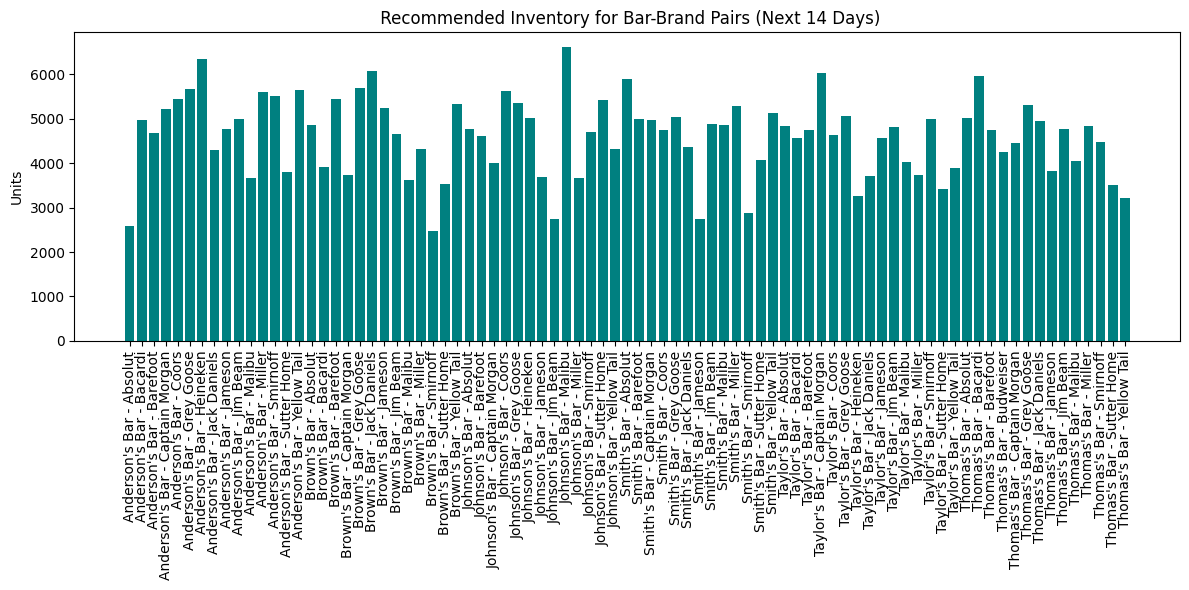

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(recommendations_df['Bar Name'] + " - " + recommendations_df['Brand Name'],
        recommendations_df['Recommended Stock'], color='teal')
plt.xticks(rotation=90)
plt.title(" Recommended Inventory for Bar-Brand Pairs (Next 14 Days)")
plt.ylabel("Units")
plt.tight_layout()
plt.show()

# Export to CSV
recommendations_df.to_csv("inventory_recommendations.csv", index=False)